<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Detect diabetic retinopathy to stop blindness before it's too late</center></h2>
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png"></center>

In this synchronous Kernels-only competition, you'll build a machine learning model to speed up disease detection. You’ll work with thousands of images collected in rural areas to help identify diabetic retinopathy automatically. If successful, you will not only help to prevent lifelong blindness, but these models may be used to detect other sorts of diseases in the future, like glaucoma and macular degeneration.

In this notebook, I will be using basic deep learning and transfer learning (ResNet50) to create a baseline.
##### Image source: http://cceyemd.com/diabetes-and-eye-exams/

### Dependencies

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [ ]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# EDA

## Data overview

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## Label class distribution

As we can see we have an unbalanced database, we have two times more class 0 than 2, and classes 1, 2 and 4 each have less than half of the class 2 data.

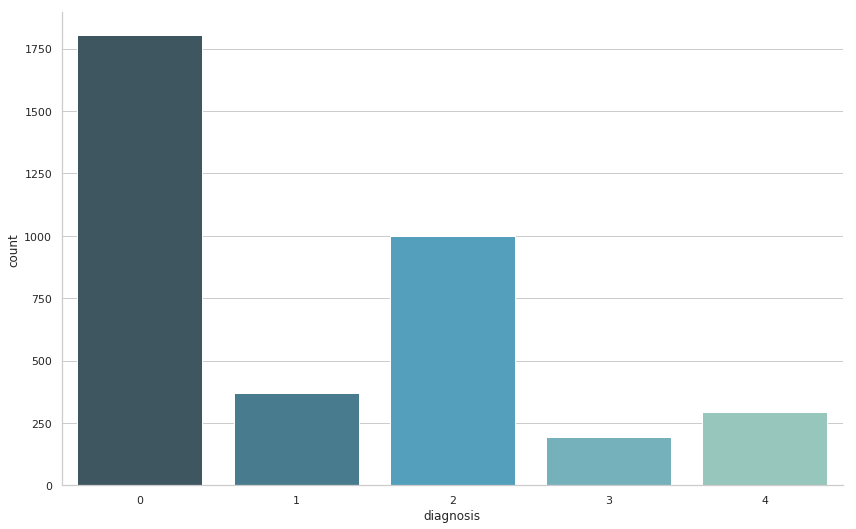

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

##### Legend
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR 

### Now let's see some of the images

The images have different sizes, they may need resizing or some padding.

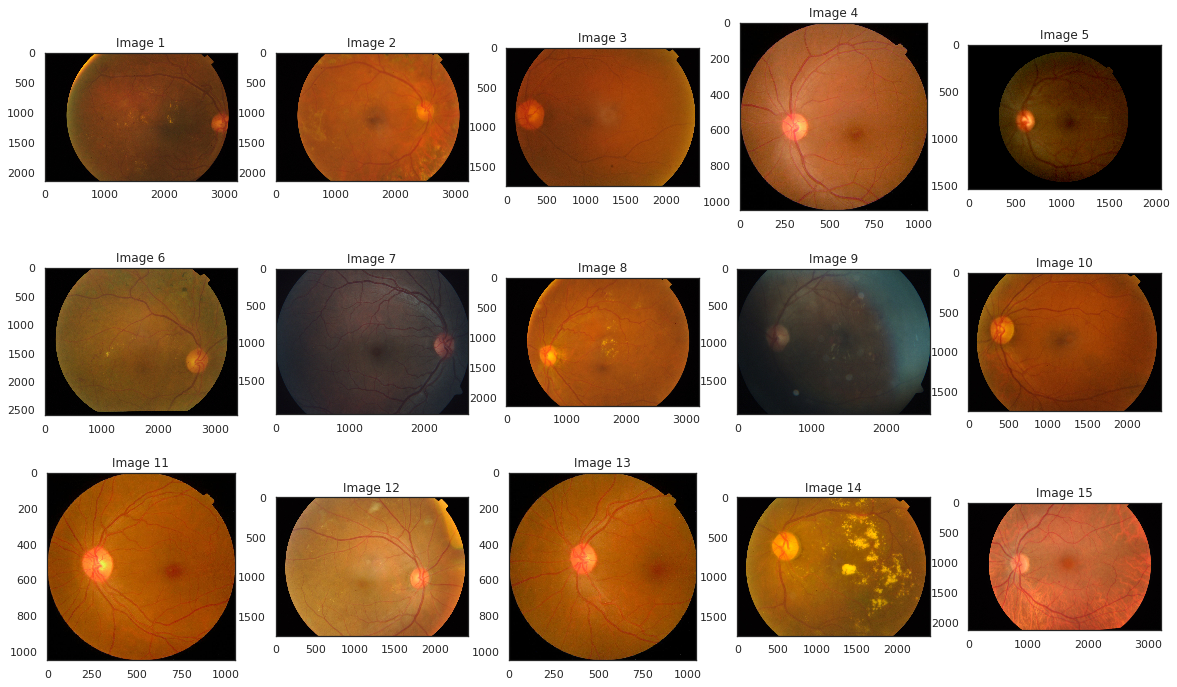

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


## Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# model visualisation
plot_model(model, 'model_1.png')

# Train top layers

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 542s 1s/step - loss: 1.2164 - acc: 0.6400 - val_loss: 4.5769 - val_acc: 0.4629
Epoch 2/2
366/366 [==============================] - 384s 1s/step - loss: 0.8422 - acc: 0.6919 - val_loss: 4.5779 - val_acc: 0.4613


# Fine-tune the complete model

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# model visualisation
plot_model(model, 'model_2.png')

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=10,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
366/366 [==============================] - 424s 1s/step - loss: 0.2180 - acc: 0.9088 - val_loss: 0.2262 - val_acc: 0.9072
Epoch 2/10
366/366 [==============================] - 405s 1s/step - loss: 0.1873 - acc: 0.9186 - val_loss: 0.1981 - val_acc: 0.9144
Epoch 3/10
366/366 [==============================] - 405s 1s/step - loss: 0.1672 - acc: 0.9283 - val_loss: 0.1871 - val_acc: 0.9213
Epoch 4/10
366/366 [==============================] - 405s 1s/step - loss: 0.1558 - acc: 0.9324 - val_loss: 0.1968 - val_acc: 0.9213
Epoch 5/10
366/366 [==============================] - 404s 1s/step - loss: 0.1418 - acc: 0.9411 - val_loss: 0.2047 - val_acc: 0.9229
Epoch 6/10
366/366 [==============================] - 403s 1s/step - loss: 0.1396 - acc: 0.9434 - val_loss: 0.1703 - val_acc: 0.9312
Epoch 7/10
366/366 [==============================] - 407s 1s/step - loss: 0.1279 - acc: 0.9486 - val_loss: 0.1534 - val_acc: 0.9356
Epoch 8/10
366/366 [==============================] - 404s 1s/step - 

# Model loss graph 

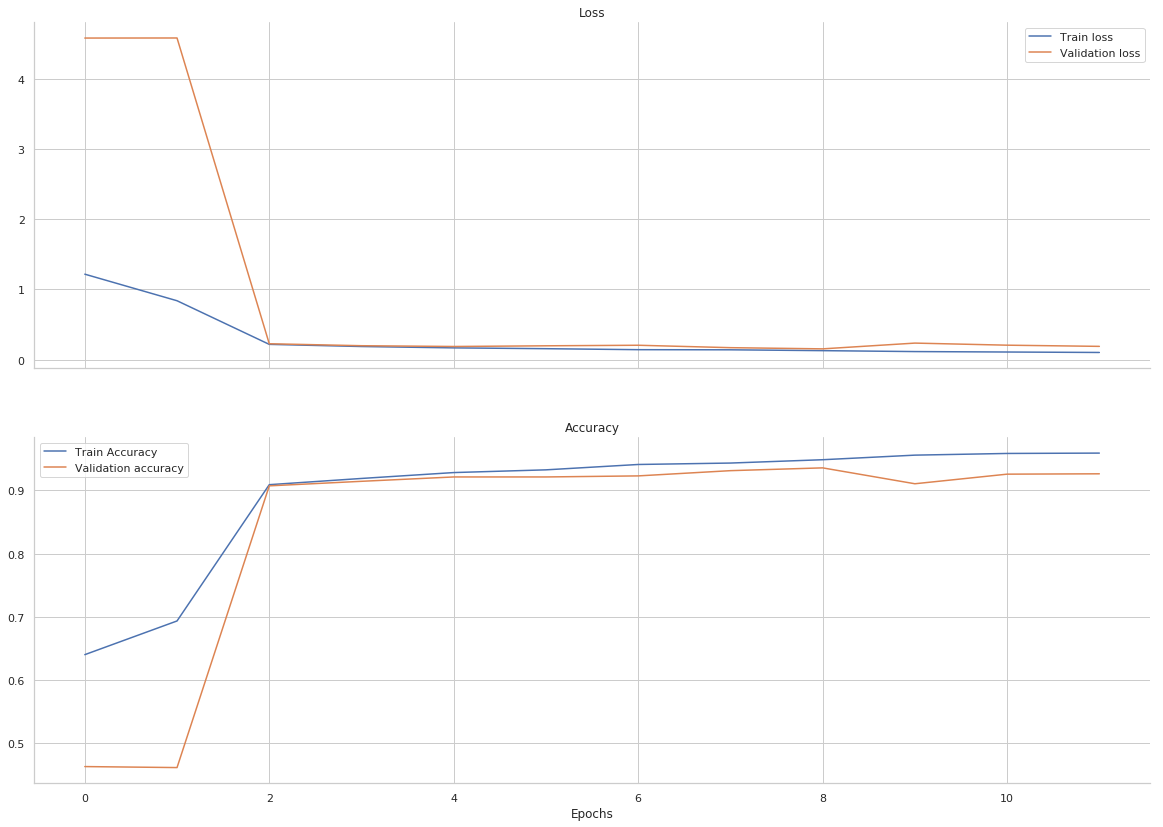

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# save model
model.save("model_blindness.h5")
model.save_weights('model_blindness_weigths.h5')

# Model Evaluation

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


## Confusion Matrix

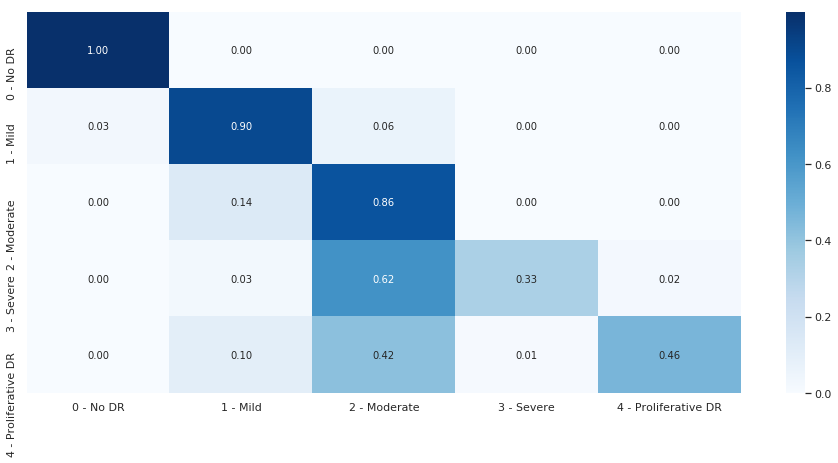

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues");

## Quadratic Weighted Kappa

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.896


# Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0


## Predictions class distribution

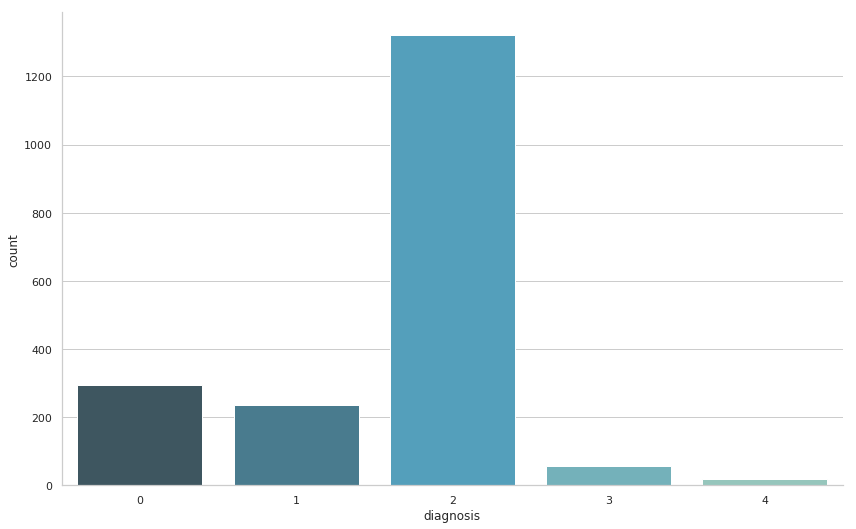

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

# Testing on Single Image

INPUT SINGLE IMAGE

  1. Reshape -> 512, 512, 3
  2. Normalization -> 1/.255

PREDICT USING TRAINED MODEL

In [1]:
# connect to my drive for load our trained model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load sample data in my repo
!git clone https://github.com/NnA301023/Blindness-Detection.git

Cloning into 'Blindness-Detection'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [4]:
# load model from weights
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Dataset/Model /model_blindness.h5")

In [6]:
# install external libraries for visualize our model
from IPython.display import clear_output
!pip install visualkeras
clear_output()

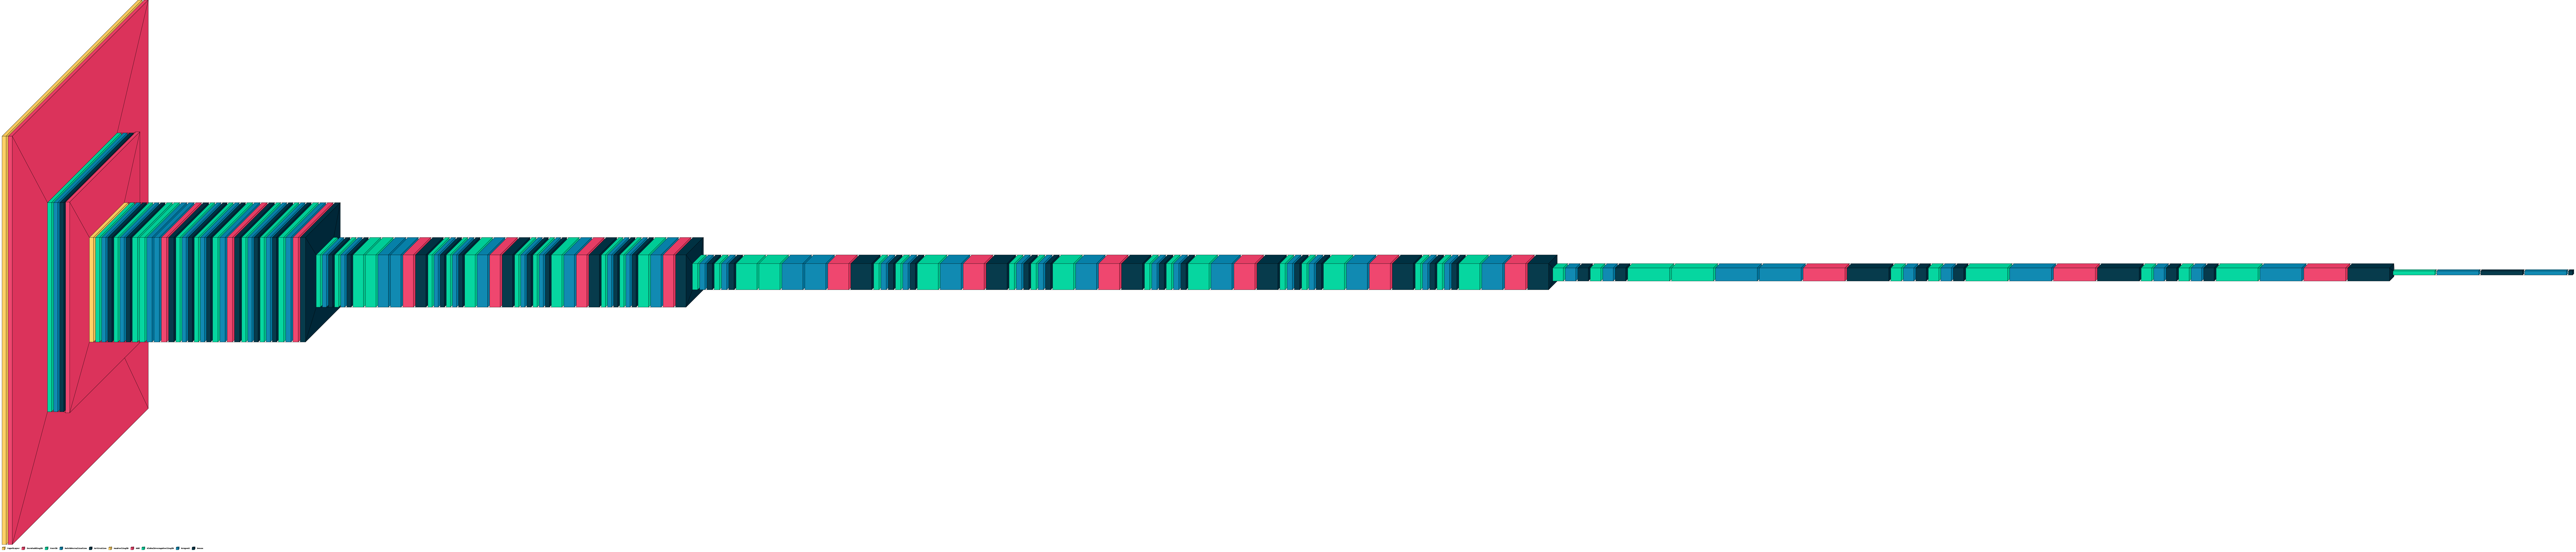

In [8]:
import visualkeras as v
v.layered_view(model, legend = True)

In [68]:
# load libraries
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [69]:
# go to data current dir
%cd "/content/Blindness-Detection/example/"

/content/Blindness-Detection/example


In [70]:
# load csv file which contains filename & label of each image(s)
data = pd.read_csv("train.csv")

In [84]:
# create main function for our testing image
def preds_eye(filename):
  img = np.expand_dims(img_to_array(load_img(filename, 
                                           target_size = (512, 512))), 
                     axis = 0)/255
  predicted_result = np.argmax(model.predict(img))
  true_label = int(data[data['id_code'] == filename.split(".")[0]]['diagnosis'])
  if predicted_result == true_label:
    plt.imshow(cv.imread(filename)[:,:,::-1])
    plt.title(f"Predicted Label is : {predicted_result}", color = 'green')
  else:
    plt.imshow(cv.imread(filename)[:,:,::-1])
    plt.title(f"Predicted Label is : {predicted_result}", color = 'red')

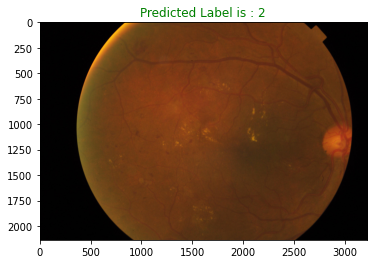

In [85]:
preds_eye("000c1434d8d7.png")

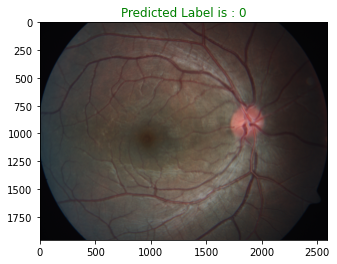

In [86]:
preds_eye("0c43c79e8cfb.png")

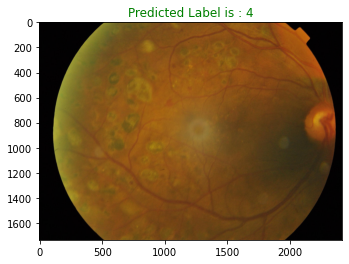

In [87]:
preds_eye("0ceb222f6629.png")